In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight # For class weights
from google.colab import drive
import joblib
import os

# --- 1. Mount Drive and Load Data ---
print("Mounting Google Drive...")
drive.mount('/content/drive')
# *** CHECK YOUR PATH ***
DRIVE_FOLDER_PATH = '/content/drive/MyDrive/dataset/'
MASTER_DATASET_FILE = os.path.join(DRIVE_FOLDER_PATH, 'master_training_dataset_v2.csv')

print(f"Loading master dataset: {MASTER_DATASET_FILE}")
try:
    df = pd.read_csv(MASTER_DATASET_FILE)
except Exception as e:
    print(f"ERROR: Could not load file. {e}")
    raise

print(f"Dataset loaded. Shape: {df.shape}")
print(df['label'].value_counts())

# --- 2. Data Preparation ---
month_order = ['06', '07', '08', '09', '10', '11', '12', '01', '02', '03', '04', '05']
features_per_month = [
    'S1_VH', 'S1_VV', 'S2_B2', 'S2_B3', 'S2_B4', 'S2_B8', 'S2_B11',
    'S2_NDVI', 'S2_NDWI', 'S2_BSI'
]
feature_columns = []
for m in month_order:
    for f in features_per_month:
        prefix = 'S1_' if f in ['S1_VH', 'S1_VV'] else 'S2_'
        feature_columns.append(f'{prefix}{f.replace("S1_","").replace("S2_","")}_{m}')

metadata_cols = ['unique_id', 'location_id', 'lon', 'lat']
label_col = 'label'

df_cleaned = df.dropna(subset=feature_columns).copy() # Use .copy()
print(f"Shape after dropping rows with NaNs: {df_cleaned.shape}")

X = df_cleaned[feature_columns]
y = df_cleaned[label_col]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_samples = X_scaled.shape[0]
n_timesteps = 12
n_features_per_step = 10
X_reshaped = X_scaled.reshape((n_samples, n_timesteps, n_features_per_step))
print(f"Data successfully reshaped to: {X_reshaped.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42, stratify=y
)

# --- 3. Build Enhanced Transformer Model ---

# *** TUNED HYPERPARAMETERS ***
def build_transformer_model_v2_1(input_shape, head_size=128, num_heads=4, ff_dim=64, num_blocks=3, dropout=0.25): # Increased blocks, adjusted ff_dim & dropout
    inputs = keras.Input(shape=input_shape)
    x = inputs
    seq_len = input_shape[0]
    position_embedding = layers.Embedding(input_dim=seq_len, output_dim=input_shape[1])
    positions = tf.range(start=0, limit=seq_len, delta=1)
    x = x + position_embedding(positions)
    x = layers.Dropout(0.1)(x) # Added dropout after embedding

    for _ in range(num_blocks): # Loop for num_blocks
        x_attn = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(x, x)
        x = layers.Add()([x, x_attn])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        x_ffn = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
        x_ffn = layers.Dropout(dropout)(x_ffn)
        x_ffn = layers.Conv1D(filters=input_shape[1], kernel_size=1)(x_ffn)
        x = layers.Add()([x, x_ffn])
        x = layers.LayerNormalization(epsilon=1e-6)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.4)(x) # Slightly increased final dropout
    x = layers.Dense(32, activation="relu")(x) # Smaller dense layer
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

model_input_shape = (X_train.shape[1], X_train.shape[2])
model = build_transformer_model_v2_1(model_input_shape) # Use new function
model.summary()

# --- 4. Compile and Train with Class Weights ---

# Calculate class weights
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))
print("Class Weights:", class_weights)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5), # Slightly lower learning rate
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print("\n--- Starting Model Training (v2.1 - Enhanced) ---")
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=150, # Increased epochs
    batch_size=32,
    class_weight=class_weights, # Apply class weights
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True) # Increased patience
    ]
)

# --- 5. Evaluate the Model ---
print("\n--- Training Finished. Evaluating Model (v2.1) ---")
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy (v2.1): {accuracy * 100:.2f}%")
print(f"Test Loss (v2.1): {loss:.4f}")

# --- 6. Save the New Model and Scaler ---
MODEL_SAVE_PATH = os.path.join(DRIVE_FOLDER_PATH, 'crop_model_v2.1.keras')
SCALER_SAVE_PATH = os.path.join(DRIVE_FOLDER_PATH, 'data_scaler_v2.1.pkl')

print(f"\nSaving model to {MODEL_SAVE_PATH}...")
model.save(MODEL_SAVE_PATH)

print(f"Saving scaler to {SCALER_SAVE_PATH}...")
joblib.dump(scaler, SCALER_SAVE_PATH)

print("\n--- All done! Model v2.1 and scaler are saved. ---")

Mounting Google Drive...
Mounted at /content/drive
Loading master dataset: /content/drive/MyDrive/dataset/master_training_dataset_v2.csv
Dataset loaded. Shape: (1988, 125)
label
0    1000
1     988
Name: count, dtype: int64
Shape after dropping rows with NaNs: (1987, 125)
Data successfully reshaped to: (1987, 12, 10)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 12, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 12, 10)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 12, 10)    │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 10)    │     22,026 │ dropout[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 12, 10)    │          0 │ dropout[0][0],    │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 12, 10)    │         20 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 12, 64)    │        704 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 12, 64)    │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 12, 10)    │        650 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 12, 10)    │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 10)    │         20 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 10)    │     22,026 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 12, 10)    │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 10)    │         20 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 12, 64)    │        704 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 12, 64)    │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 12, 10)    │        650 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 12, 10)    │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 12, 10)    │         20 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 70,645 (275.96 KB)

 Trainable params: 70,645 (275.96 KB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: np.float64(0.9943679599499374), 1: np.float64(1.0056962025316456)}

--- Starting Model Training (v2.1 - Enhanced) ---
Epoch 1/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 251ms/step - accuracy: 0.4455 - loss: 0.7796 - val_accuracy: 0.6985 - val_loss: 0.6518
Epoch 2/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5510 - loss: 0.6982 - val_accuracy: 0.7437 - val_loss: 0.6191
Epoch 3/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5798 - loss: 0.6704 - val_accuracy: 0.7739 - val_loss: 0.5944
Epoch 4/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5702 - loss: 0.6590 - val_accuracy: 0.7915 - val_loss: 0.5687
Epoch 5/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6674 - loss: 0.6152 - val_accuracy: 0.8116 - val_loss: 0.5373
Epoch 6/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6641 - loss: 0.6046 - val_accuracy: 0.8291 - val_loss: 0.5068
Epoch 7/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6933 - loss: 0.5774 - val_accur

Mounting Google Drive...
--- Loading Model v2.1 and Scaler ---
Model v2.1 and scaler loaded successfully.
GEE Initialized.
Extracting 12-month time-series (10 features) from GEE (2020-06-01 to 2021-06-01)...
...Extraction complete.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step

    LIVE PREDICTION REPORT (v2.1 Model, Threshold=0.4)
  Coordinates: (14.4502761630272, 79.5551608856812)
  Model Predicts:  CROP
  Raw Probability (Crop=1): 0.5023
  Confidence:      50.23%

See 'live_manual_test_v2.1_charts_thresh04.png' for the chart.


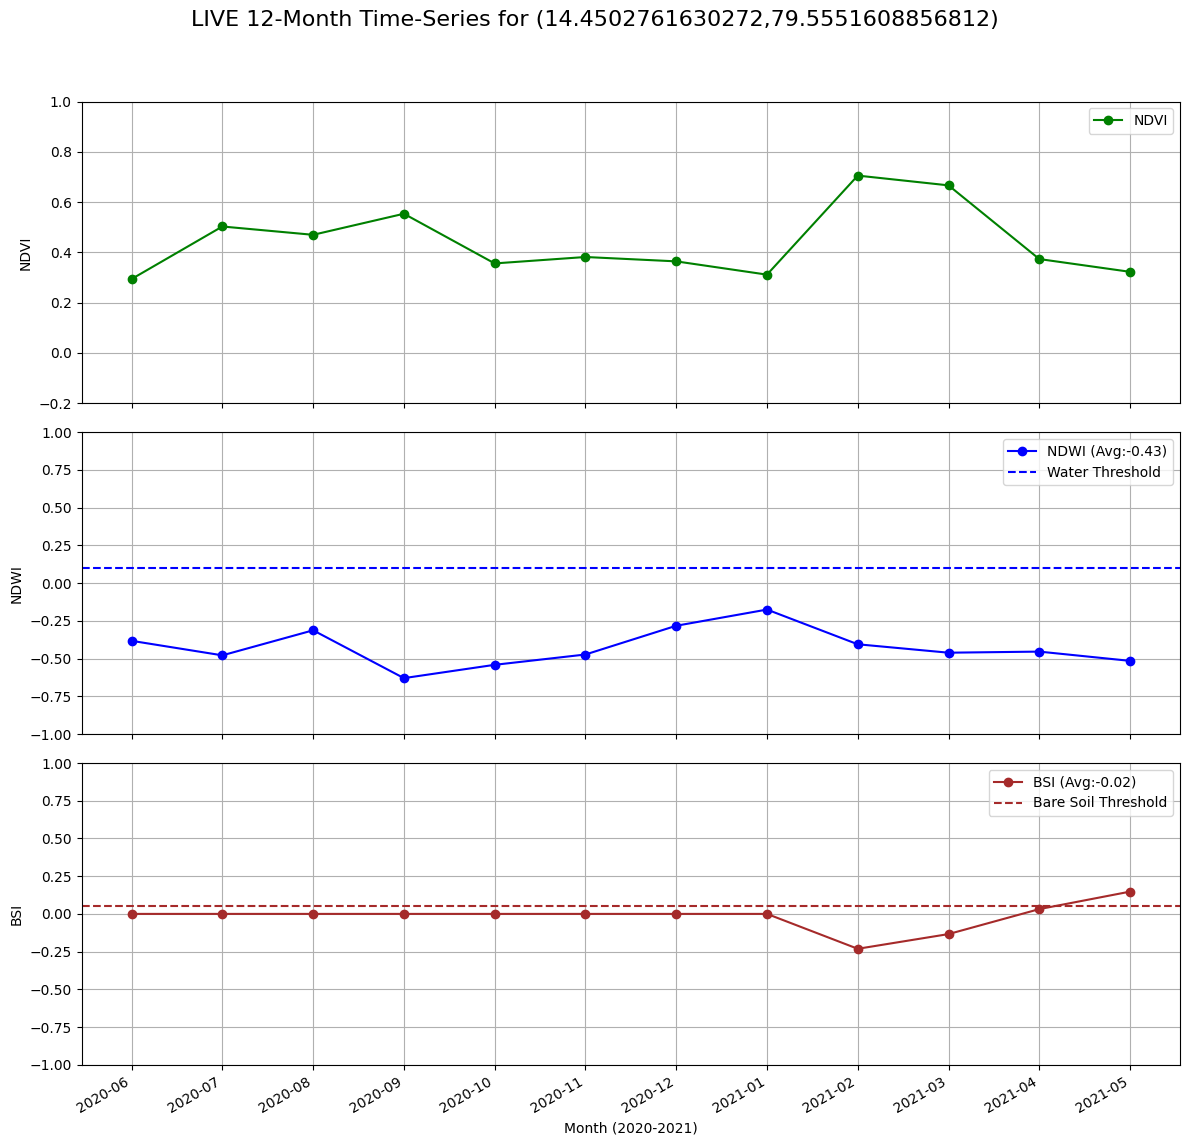

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import joblib
import matplotlib.pyplot as plt
import os
import ee
from google.colab import drive
import time

print("Mounting Google Drive...")


# --- 1. Configuration ---
# *** CHECK PATH ***
DRIVE_FOLDER_PATH = '/content/drive/MyDrive/dataset/'
# *** LOAD v2.1 MODEL AND SCALER ***
MODEL_PATH = os.path.join(DRIVE_FOLDER_PATH, 'crop_model_v2.1.keras')
SCALER_PATH = os.path.join(DRIVE_FOLDER_PATH, 'data_scaler_v2.1.pkl')

# --- 2. SET TEST COORDINATES (Use the same coordinates) ---
TEST_LON = 79.5551608856812

TEST_LAT =14.4502761630272
# --- 3. SET DATE RANGE TO MATCH TRAINING DATA ***
START_DATE = '2020-06-01'
END_DATE = '2021-06-01'

# *** 4. NEW THRESHOLD ***
PREDICTION_THRESHOLD = 0.4 # Lowered from 0.5

print("--- Loading Model v2.1 and Scaler ---")
# (Loading and GEE Init code - same as before)
try:
    model = keras.models.load_model(MODEL_PATH)
    scaler = joblib.load(SCALER_PATH)
    print("Model v2.1 and scaler loaded successfully.")
    try: ee.Initialize(project="moonlit-state-475112-b5")
    except Exception as e: ee.Authenticate(); ee.Initialize(project="moonlit-state-475112-b5")
    print("GEE Initialized.")
except Exception as e: print(f"!!! ERROR loading files: {e}"); raise

# --- 5. GEE HELPER FUNCTIONS (Same as before) ---
def maskS2clouds(image):
    qa = image.select('QA60'); cloudBitMask=1<<10; cirrusBitMask=1<<11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    scl = image.select('SCL'); good_quality = scl.eq(4).Or(scl.eq(5)).Or(scl.eq(6)).Or(scl.eq(7)).Or(scl.eq(11))
    required_bands = ['B2', 'B3', 'B4', 'B8', 'B11']
    return image.updateMask(mask).updateMask(good_quality).divide(10000) \
        .select(required_bands).copyProperties(image, ["system:time_start"])

def calculate_indices_and_bands(image):
    ndvi=image.normalizedDifference(['B8','B4']).rename('NDVI')
    ndwi=image.normalizedDifference(['B3','B11']).rename('NDWI')
    bsi_n=(image.select('B11').add(image.select('B4'))).subtract(image.select('B8').add(image.select('B2')))
    bsi_d=(image.select('B11').add(image.select('B4'))).add(image.select('B8').add(image.select('B2')))
    bsi=bsi_n.divide(bsi_d).rename('BSI').toFloat().unmask(None)
    return image.addBands(ndvi).addBands(ndwi).addBands(bsi).select(['B2','B3','B4','B8','B11','NDVI','NDWI','BSI'])

S2_BANDS_NEEDED = ['B2','B3','B4','B8','B11','NDVI','NDWI','BSI']
S1_BANDS = ['VV', 'VH']

# --- 6. LIVE GEE EXTRACTION FUNCTION (Same as before) ---
def get_live_timeseries_v3_all_features(lon, lat):
    point=ee.Geometry.Point([lon, lat]); dates_full=pd.date_range(start=START_DATE, end=END_DATE, freq='MS', inclusive='both')
    start_dates=dates_full[:-1]; end_dates=dates_full[1:]; time_steps=list(zip(start_dates, end_dates))
    chart_months=[d.strftime('%Y-%m') for d in start_dates]
    print(f"Extracting 12-month time-series (10 features) from GEE ({START_DATE} to {END_DATE})...")
    final_feature_vector=[]
    s2_masked=ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterBounds(point).filterDate(START_DATE,END_DATE).map(maskS2clouds)
    s2_processed=s2_masked.map(calculate_indices_and_bands)
    s1_collection=ee.ImageCollection('COPERNICUS/S1_GRD').filterDate(START_DATE,END_DATE).filter(ee.Filter.listContains('transmitterReceiverPolarisation','VV')).filter(ee.Filter.listContains('transmitterReceiverPolarisation','VH')).filter(ee.Filter.eq('instrumentMode','IW')).filterBounds(point).select(S1_BANDS)
    for start, end in time_steps:
        date_start_str=start.strftime('%Y-%m-%d'); date_end_str=end.strftime('%Y-%m-%d')
        monthly_s2=s2_processed.filterDate(date_start_str,date_end_str); s2_count=monthly_s2.size().getInfo()
        monthly_s2_median=ee.Image(ee.Algorithms.If(s2_count>0, monthly_s2.median().rename(S2_BANDS_NEEDED),
                                                  ee.Image.constant([None]*len(S2_BANDS_NEEDED)).toFloat().rename(S2_BANDS_NEEDED)))
        monthly_s1=s1_collection.filterDate(date_start_str,date_end_str); s1_count=monthly_s1.size().getInfo()
        monthly_s1_median=ee.Image(ee.Algorithms.If(s1_count>0, monthly_s1.median().rename(S1_BANDS),
                                                  ee.Image.constant([None]*len(S1_BANDS)).toFloat().rename(S1_BANDS)))
        composite=monthly_s2_median.addBands(monthly_s1_median)
        try:
            data=composite.reduceRegion(reducer=ee.Reducer.firstNonNull(),geometry=point,scale=10).getInfo()
            final_feature_vector.append(data.get('VH', None)); final_feature_vector.append(data.get('VV', None))
            final_feature_vector.append(data.get('B2', None)); final_feature_vector.append(data.get('B3', None))
            final_feature_vector.append(data.get('B4', None)); final_feature_vector.append(data.get('B8', None))
            final_feature_vector.append(data.get('B11', None)); final_feature_vector.append(data.get('NDVI', None))
            final_feature_vector.append(data.get('NDWI', None)); final_feature_vector.append(data.get('BSI', None))
        except Exception as e: print(f"  Warning: Error processing {start.strftime('%Y-%m')}: {e}. Appending Nones."); final_feature_vector.extend([None]*10)
        time.sleep(0.5)
    print("...Extraction complete.")
    return final_feature_vector,chart_months

# --- 7. RUN PREDICTION ---
try:
    live_features, chart_months = get_live_timeseries_v3_all_features(TEST_LON, TEST_LAT)
    if len(live_features)!=120: print(f"ERROR: GEE extraction returned {len(live_features)} features, expected 120."); live_features.extend([None]*(120-len(live_features)))
    live_features_numeric = [np.nan if f is None else f for f in live_features]
    live_data_np=np.array(live_features_numeric, dtype=float).reshape(1,-1)
    nan_count_pre_scale = np.isnan(live_data_np).sum()
    imputed_value = 0.0
    if nan_count_pre_scale > 0: print(f"Warning: {nan_count_pre_scale} missing values detected before scaling. Imputing with {imputed_value}."); live_data_np = np.nan_to_num(live_data_np, nan=imputed_value)
    live_data_scaled = scaler.transform(live_data_np)
    if np.isnan(live_data_scaled).any(): print("Warning: NaNs after scaling. Replacing with 0."); live_data_scaled = np.nan_to_num(live_data_scaled, nan=0.0)
    live_data_reshaped=live_data_scaled.reshape((1,12,10))

    # *** MAKE PREDICTION & APPLY NEW THRESHOLD ***
    prediction_raw_prob=model.predict(live_data_reshaped)[0][0]
    prediction_label_name="CROP" if prediction_raw_prob > PREDICTION_THRESHOLD else "NON-CROP" # Use new threshold
    confidence=prediction_raw_prob if prediction_label_name=="CROP" else 1-prediction_raw_prob

    # --- 8. Add Sub-Class Logic ---
    ndvi_values=[live_features_numeric[i+7] for i in range(0,120,10)]
    ndwi_values=[live_features_numeric[i+8] for i in range(0,120,10)]
    bsi_values=[live_features_numeric[i+9] for i in range(0,120,10)]
    ndwi_mean=np.nanmean(ndwi_values)
    bsi_mean=np.nanmean(bsi_values)
    final_display_label=""
    if prediction_label_name=="CROP": final_display_label="CROP"
    else: # Sub-classify Non-Crop
        if not np.isnan(ndwi_mean) and ndwi_mean > 0.1: final_display_label="NON-CROP (Identified as Water)"
        elif not np.isnan(bsi_mean) and bsi_mean > 0.05: final_display_label="NON-CROP (Identified as Barren Soil)"
        else: final_display_label="NON-CROP (Identified as Built-up/Other)"

    # --- 9. Print the Final Report ---
    print("\n"+"="*55); print(f"    LIVE PREDICTION REPORT (v2.1 Model, Threshold={PREDICTION_THRESHOLD})")
    print("="*55); print(f"  Coordinates: ({TEST_LAT}, {TEST_LON})")
    print(f"  Model Predicts:  {final_display_label}"); print(f"  Raw Probability (Crop=1): {prediction_raw_prob:.4f}")
    print(f"  Confidence:      {confidence*100:.2f}%"); print("="*55)

    # --- 10. PLOT THE CHARTS ---
    # (Plotting code remains the same as previous correct version)
    fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(12,12),sharex=True)
    fig.suptitle(f"LIVE 12-Month Time-Series for ({TEST_LAT},{TEST_LON})",fontsize=16)
    ndvi_plot=np.array(ndvi_values, dtype=float); ndwi_plot=np.array(ndwi_values, dtype=float)
    bsi_plot=np.array(bsi_values, dtype=float); chart_months_arr=np.array(chart_months)
    valid_ndvi=~np.isnan(ndvi_plot); nan_ndvi=np.isnan(ndvi_plot)
    if np.any(valid_ndvi): ax1.plot(chart_months_arr[valid_ndvi],ndvi_plot[valid_ndvi],marker='o',color='green',label="NDVI")
    if np.any(nan_ndvi): num_nan=np.sum(nan_ndvi); ax1.scatter(chart_months_arr[nan_ndvi],[-0.1]*num_nan,color='red',marker='x',s=100,label='No Data')
    ax1.set_ylabel("NDVI"); ax1.set_ylim(-0.2,1); ax1.grid(True); ax1.legend()
    valid_ndwi=~np.isnan(ndwi_plot); nan_ndwi=np.isnan(ndwi_plot)
    if np.any(valid_ndwi): ax2.plot(chart_months_arr[valid_ndwi],ndwi_plot[valid_ndwi],marker='o',color='blue',label=f"NDWI (Avg:{ndwi_mean:.2f})")
    if np.any(nan_ndwi): num_nan=np.sum(nan_ndwi); ax2.scatter(chart_months_arr[nan_ndwi],[-0.9]*num_nan,color='red',marker='x',s=100,label='No Data')
    ax2.axhline(y=0.1,color='blue',linestyle='--',label='Water Threshold'); ax2.set_ylabel("NDWI"); ax2.set_ylim(-1,1); ax2.grid(True); ax2.legend()
    valid_bsi=~np.isnan(bsi_plot); nan_bsi=np.isnan(bsi_plot)
    if np.any(valid_bsi): ax3.plot(chart_months_arr[valid_bsi],bsi_plot[valid_bsi],marker='o',color='brown',label=f"BSI (Avg:{bsi_mean:.2f})")
    if np.any(nan_bsi): num_nan=np.sum(nan_bsi); ax3.scatter(chart_months_arr[nan_bsi],[-0.9]*num_nan,color='red',marker='x',s=100,label='No Data')
    ax3.axhline(y=0.05,color='brown',linestyle='--',label='Bare Soil Threshold'); ax3.set_ylabel("BSI"); ax3.set_ylim(-1,1)
    ax3.set_xlabel("Month (2020-2021)"); ax3.grid(True); ax3.legend()
    fig.autofmt_xdate(); plt.tight_layout(rect=[0,0.03,1,0.95]); plt.savefig("live_manual_test_v2.1_charts_thresh04.png")
    print("\nSee 'live_manual_test_v2.1_charts_thresh04.png' for the chart.")

except Exception as e: print(f"\n--- An Error Occurred ---\n{e}")



In [ ]:
!pip list | grep -E 'earthengine-api|google-api-python-client|protobuf|numpy|tensorflow'

earthengine-api                          1.5.24
google-api-python-client                 2.185.0
numpy                                    2.0.2
protobuf                                 5.29.5
tensorflow                               2.19.0
tensorflow-datasets                      4.9.9
tensorflow_decision_forests              1.12.0
tensorflow-hub                           0.16.1
tensorflow-metadata                      1.17.2
tensorflow-probability                   0.25.0
tensorflow-text                          2.19.0
